In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

from src.toep_gmg import Toep_GMG1D
from src.green_net import GreenNet1D
from src.model import MLP
from src.utils import rl2_error

In [2]:
def Logarithm(pts):
    x = pts[...,0]
    y = pts[...,1]

    return torch.nan_to_num(torch.log((x-y).abs()), neginf=-5)

In [3]:
device = torch.device('cpu')
# kernel = MLP([2, 64, 1], nonlinearity='relu').to(device)
model = GreenNet1D(n=5, kernel=Logarithm, device=device, sub_num=5)

In [4]:
F = torch.squeeze(1 - model.grid.x_h**2)
F = repeat(F, 'n -> n b', b=64)

Evaluation Points Position

torch.Size([1089, 2])


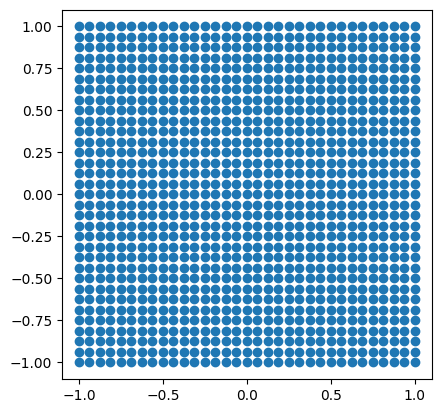

In [5]:
plt.scatter(model.pts[:,0], model.pts[:,1])
plt.gca().set_aspect('equal')
print(model.pts.shape)

Ground Truth Kernel Function

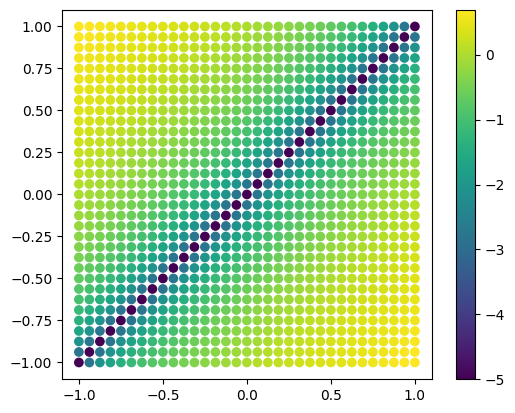

In [6]:
model.eval_K()
K_full = model.K_hh
plt.scatter(model.pts[:,0], model.pts[:,1], c=K_full)
plt.gca().set_aspect('equal')
plt.colorbar()

Full Kernel Integral 

In [7]:
U_full = model.full_kint(F)
print(U_full.shape)

torch.Size([33, 64])


Text(0.5, 1.0, 'output function U')

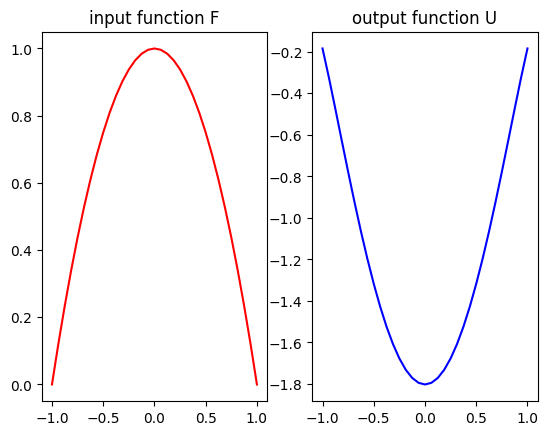

In [8]:
plt.subplot(121)
plt.plot(model.grid.x_h, F[:,0], '-r')
plt.title('input function F')
plt.subplot(122)
plt.plot(model.grid.x_h, U_full[:,0], '-b')
plt.title('output function U')

# Test Eval Batch

In [9]:
model.rand_sub()
print('random sub : ', model.sub)
model.eval_K_sub()
U_sub = model.sub_kint(F)

random sub :  tensor([32, 22, 11, 22, 12])


tensor(3.2345e-08)


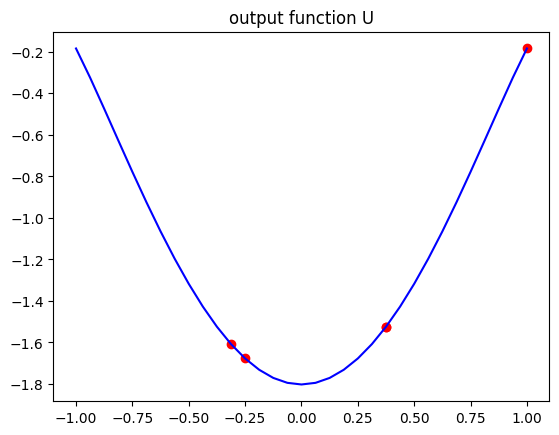

In [10]:
plt.plot(model.grid.x_h, U_full[:,0], '-b')
plt.scatter(model.grid.x_h[model.sub], U_sub[:,0], color='red')
plt.title('output function U')
print(rl2_error(U_sub, U_full[model.sub]))

# Test Batch Kint

In [11]:
model.eval_K_batch(bsz=5)

In [12]:
K_batch = model.K_hh
U_batch = model.batch_kint(F)
print('K rl2 : ' , rl2_error(K_batch, K_full))
print('U rl2 : ' , rl2_error(U_batch, U_full))

K rl2 :  tensor(0.)
U rl2 :  tensor(0.)
